# RPPA Network Analysis - Exploratory data analysis workflow
### Requires:
Cytoscape 3.10.0 or later

Jupyter notebook v2023.4.1011241018 or later

Python 3.10.9 or later

Python packages:
    
    py4cytoscape
    pandas
    numpy
    scipy


## Step 1: Start Cytoscape on your computer
## Step 2: Run code blocks below in order

### 2.A: Import Python packages and connect to Cytoscape (Local)

In [ ]:
# Import python packages
import pandas as pd
import numpy as np
import py4cytoscape as p4c
from tkinter import filedialog as FD
from numpy.random import seed
from scipy.stats import shapiro
from scipy import stats

# Check cystoscape connection
p4c.cytoscape_version_info()

### 2.B: Select CSV file containing network structure information

In [ ]:
# Import Network map data from csv
nmap_csv = FD.askopenfilename()
edge_data = pd.read_csv(nmap_csv).dropna(how='all')
edge_data.head()

### 2.C: Select CSV file containing endpoint data

In [ ]:
# Import Enpoint data csv
csvfile = FD.askopenfilename()
original_data = pd.read_csv(csvfile).dropna(how='all')
for col in original_data.columns[3:]:
    original_data[col] = pd.to_numeric(original_data[col], errors='coerce')

## Imputes any string values within each endpoint
# Count endpoints variable
num_columns = original_data.shape[1]
# Temp data object for Group_2 endpoint values only
Group_2_fill = original_data[original_data.iloc[:,2] == "Group_2"]
# Temp data object for Group_1 endpoint values only
Group_1_fill = original_data[original_data.iloc[:,2] == "Group_1"]
# Iterate through endpoint columns and imputes string values for minimum value of tissue type divided by 2
for i in range(3,num_columns):
    # Selects minimum value for Group_2 data within endpoint data
    min_val_t = Group_2_fill.iloc[:,i].min()
    # Imputes strings for Group_2 values within endpoint data
    Group_2_fill.iloc[:, i].fillna(min_val_t / 2, inplace=True)
    # Selects minimum value for Group_1 data within endpoint data
    min_val_s = Group_1_fill.iloc[:,i].min()
    # Imputes strings for Group_1 values within endpoint data
    Group_1_fill.iloc[:, i].fillna(min_val_t / 2, inplace=True)
# Updates original dataframe
original_data.update(Group_2_fill)
original_data.update(Group_1_fill)

original_data.head()

In [ ]:
# Compare Group_2 to Group_1
## Determine if data is parametric or not
# Seed random number generator
seed(1)
# Alpha value for p-value significance
alpha = 0.05
# Count endpoints variable
num_columns = original_data.shape[1]
# List of endpoints with results
e_list = []
# List of p-value results
p_list = []
# List of Group_2 means
t_means = []
# List of Group_2 sd
t_sds = []
# List of Group_2 cv
t_cvs = []
# List of Group_1 means
s_means = []
# List of Group_1 sd
s_sds = []
# List of Group_1 cv
s_cvs = []
# List of significant or not
sign_list = []
for i in range(3,num_columns):
    # Endpoint value column variable
    endpoint = original_data.iloc[:,i]
    # Targets endpoint value column name
    e_name = original_data.iloc[:,i].name
    print(e_name)
    # Normality test (Shapiro-Wilk Test)
    stat, p_value = shapiro(endpoint)
    # Select only Group_2 data
    Group_2 = original_data[original_data.iloc[:,2] == "Group_2"].iloc[:,i]
    # Group_2 mean
    Group_2_mean = Group_2.mean()
    t_means.append(Group_2_mean)
    # Group_2 stdev
    Group_2_stdev = Group_2.std()
    t_sds.append(Group_2_stdev)
    # Group_2 cv
    Group_2_cv = (Group_2_stdev / Group_2_mean) * 100
    t_cvs.append(Group_2_cv)
    # Select only Group_1 data
    Group_1 = original_data[original_data.iloc[:,2] == "Group_1"].iloc[:,i]
    # Group_1 mean
    Group_1_mean = Group_1.mean()
    s_means.append(Group_1_mean)
    # Group_1 stdev
    Group_1_stdev = Group_1.std()
    s_sds.append(Group_1_stdev)
    # Group_1 cv
    Group_1_cv = (Group_1_stdev / Group_1_mean) * 100
    s_cvs.append(Group_1_cv)
    ## Action loop for p-value result
    # If parametric, calculates Pearson correlation coefficient
    if p_value > alpha:
        # Print result of parametric test
        print("Parametric, fail to reject H0")
        # Run Pearson correlation coefficient function
        stat2, p_value2 = stats.pearsonr(Group_2,Group_1)
        # Add endpoint that had values used to list
        e_list.append(e_name)
        # Add p-value result to list
        p_list.append(p_value2)
        # Interprets if endpoint is significant
        if p_value2 < alpha:
            # Prints result
            print("Reject the null hypothesis: Correlation between samples is statistically significant.")
            # Add significance to list
            sign_list.append("Yes")
        else:
            # Prints result
            print("Fail to reject the null hypothesis: Correlation between samples not is statistically significant.")
            # Add non-significance to list
            sign_list.append("No")
    # If nonparametric, calculates Spearman rank-order correlation coefficient
    else:
        # Print result of parametric test
        print("Nonparametric, reject H0")
        # Run Spearman rank-order correlation coefficient function
        stat2, p_value2 = stats.spearmanr(Group_2,Group_1,nan_policy='omit')
        # Add endpoint that had values used to list
        e_list.append(e_name)
        # Add p-value result to list
        p_list.append(p_value2)
        # Interprets if endpoint is significant
        if p_value2 < alpha:
            # Prints result
            print("Reject null hypothesis: Correlation between samples is statistically significant.")
            # Add significance to list
            sign_list.append("Yes")
        else:
            # Prints result
            print("Fail to reject null hypothesis: Correlation between samples not is statistically significant.")
            # Add non-significance to list
            sign_list.append("No")
# Makes dictionary of endpoints and results
d = {'endpoints':e_list,
     'p_values':p_list,
     'Group_2_means':t_means,
     'Group_2_stdev':t_sds,
     'Group_2_cv':t_cvs,
     'Group_1_means':s_means,
     'Group_1_stdev':s_sds,
     'Group_1_cv':s_cvs,
     'significant':sign_list
     }
# Takes dictionary and creates dataframe
end_and_pvalues = pd.DataFrame(data=d)
# Shows dataframe
end_and_pvalues.head()

In [ ]:
# Calculate deltas of Group_2 means compared to Group_1 for significant enpoints
endpoints = []
values = []
significant = end_and_pvalues[end_and_pvalues["significant"] == "Yes"]
for index, row in significant.iterrows():
    endpoints.append(row['endpoints'])
    value = row['Group_2_means'] - row['Group_1_means']
    values.append(value)
delta_mean = {'id':endpoints, 'Endpoint':values}
# Create dataframe from delta means of significant endpoints
nodes = pd.DataFrame.from_dict(data=delta_mean,orient='columns')
nodes.head()

In [ ]:
# Create dataframe for network interactions
topography = {'source':edge_data.iloc[:,0],
             'target':edge_data.iloc[:,1]
            }
edges = pd.DataFrame(data=topography, columns=['source', 'target'])
edges.head()

In [ ]:
# Use network interaction dataframe to create network
p4c.create_network_from_data_frames(edges=edges, title='Significant Endpoints network', collection="rppa collection")

In [ ]:
# Loads total protein values to node table in cytoscape
p4c.load_table_data(nodes, data_key_column='id', table='node', table_key_column='name')

In [ ]:
# Set nodes' default color to grey
p4c.set_visual_property_default({'visualProperty': 'NODE_FILL_COLOR', 'value': 'lightgrey'})

In [ ]:
# Set nodes' default color to grey
# Grey nodes for no data or non-significant endpoints
from py4cytoscape import palette_color_brewer_d_RdBu
p4c.set_visual_property_default({'visualProperty': 'NODE_FILL_COLOR', 'value': 'lightgrey'})
# Apply color gradient to nodes corresponding to endpoint value
p4c.set_node_color_mapping(**p4c.gen_node_color_map('Endpoint', palette_color_brewer_d_RdBu(),mapping_type='c'))

In [ ]:
# Analyze network, generate network values, and apply network values to node and edge tables
p4c.analyze_network()

In [ ]:
# Export network image to jupyter notebook
p4c.notebook_export_show_image()

## Step 3: Create legend
### 3.A Go to the Style tab
### 3.B Click three horizontal lines button 
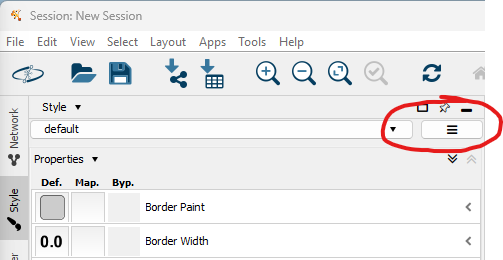
### 3.C Select "Create Legend"